In [1]:
import pandas as pd
from functions import *
import seaborn
import csv
import subprocess
import os
path = 'C:/Users/6997619/Documents/GitHub projects/DHZW-simulation_Sim-2APL/src/main/resources/calibration/'

Imported successfully


In [7]:
X_train = pd.read_csv(path+"data/X_train.csv")
X_test = pd.read_csv(path+"data/X_test.csv")

## Calculate fitness

In [8]:
output = pd.read_csv(path+'output/output_proportions.csv')
output

,CAR_DRIVER,CAR_PASSENGER,BIKE,BUS_TRAM,TRAIN,WALK
0,0.027988,0.297281,0.286106,0.091091,0.008263,0.289272
1,0.063858,0.144649,0.368777,0.043071,0.021469,0.358175
2,0.008636,0.483806,0.180547,0.147030,0.002018,0.177964
3,0.024075,0.225548,0.354371,0.027010,0.015168,0.353828
4,0.047520,0.600563,0.139711,0.070953,0.001022,0.140230
...,...,...,...,...,...,...
215,0.008176,0.281746,0.312825,0.067135,0.021877,0.308241
216,0.016739,0.627563,0.105476,0.148440,0.001379,0.100402
217,0.075018,0.138637,0.380377,0.031570,0.003816,0.370581
218,0.011628,0.473696,0.199966,0.111944,0.007325,0.195441


In [2]:
observed_values = pd.read_csv(path+'data/observed_mode_choice.csv')
observed_values

,CAR_DRIVER,CAR_PASSENGER,BIKE,BUS_TRAM,TRAIN,WALK
0,0.29,0.12,0.16,0.15,0.03,0.25


In [10]:
# for each mode choice, calculate the difference between observed and simulated data. weight by obrserved data
df = observed_values.values[0] * abs(output - observed_values.values[0]) * 100

# aggregate in one fitness score
df['fitness'] = df.sum(axis=1)

print(df)

# leave only the fitness score
df = df['fitness']

     CAR_DRIVER  CAR_PASSENGER      BIKE  BUS_TRAM     TRAIN      WALK  \
0      7.598361       2.127370  2.017698  0.883639  0.065212  0.981807   
1      6.558106       0.295793  3.340432  1.603938  0.025593  2.704387   
2      8.159564       4.365671  0.328744  0.044555  0.083946  1.800891   
3      7.711827       1.266571  3.109941  1.844849  0.044497  2.595710   
4      7.031918       5.766758  0.324629  1.185701  0.086933  2.744242   
..          ...            ...       ...       ...       ...       ...   
215    8.172897       1.940952  2.445200  1.242970  0.024370  1.456024   
216    7.924560       6.090754  0.872377  0.023398  0.085862  3.739953   
217    6.234473       0.223649  3.526037  1.776449  0.078552  3.014521   
218    8.072785       4.244351  0.639454  0.570840  0.068024  1.363976   
219    7.460754       0.299121  3.933827  1.428644  0.052707  3.728550   

       fitness  
0    13.674088  
1    14.528249  
2    14.783372  
3    16.573395  
4    17.140181  
..       

## Organising the output

In [11]:
y_train = df.head(X_train.shape[0])
y_test = df.tail(X_test.shape[0])

## Surrogate model

### Compute the XGBoost Surrogate

In [12]:
# This surrogate will not have multiple iterations. It will run on the entire budget of evaluations.
surrogate_model_XGBoost = fit_surrogate_model(X_train, y_train)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2041
Function value obtained: 1.0031
Current minimum: 1.0031
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2785
Function value obtained: 0.2207
Current minimum: 0.2207
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8828
Function value obtained: 0.6870
Current minimum: 0.2207
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5590
Function value obtained: 0.9207
Current minimum: 0.2207
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.9092
Function value obtained: 0.6581
Current minimum: 0.2207
Iteration No: 6 started. Evaluating

### Predict test set surrogate model

In [13]:
y_hat_test = surrogate_model_XGBoost.predict(X_test)

### Evaluate surrogate model on the test set

In [14]:
model_fitness = mean_squared_error(y_test, y_hat_test)

print(model_fitness)

10.612379884524035


### Find optimal parameter set

In [15]:
# Set the ABM parameters and support
parameters_range = np.array([
    (-2.0, 2.0),
    (-2.0, 2.0),
    (-2.0, 2.0),
    (-2.0, 2.0)])

pool_size = 1000000
pool = get_sobol_samples(parameters_range.shape[0], pool_size, parameters_range) # generate (with the Sobol sampling) a large set of parameters combinations. Quantity based on the budget

In [16]:
Y_hat = surrogate_model_XGBoost.predict(pool)

In [22]:
print('Mean: ' + str(np.mean(Y_hat)))
print('SD ' + str(np.std(Y_hat)))

Mean: 15.231584
SD 2.4568853


In [29]:
best_parameter_set = pool[np.argmin(Y_hat)]
best_parameter_set_with_fitness = np.append(best_parameter_set, min(Y_hat))
print(best_parameter_set_with_fitness)

[1.85026932 0.06657028 0.05263901 0.99746323 9.73578644]


In [24]:
best_parameter_set = pd.DataFrame([best_parameter_set], columns=['alphaLeisureCarPassenger',
                                           'alphaLeisureTram',
                                           'alphaSchoolBus',
                                           'alphaWorkBus',
                                           'alphaWorkTrain',
                                           'betaChangesTransportLeisure',
                                           'betaChangesTransportSchool',
                                           'betaChangesTransportWork'])

best_parameter_set.to_csv(path+"optimal_parameterset/best_parameterset.csv", header=True, index=None)

   alphaLeisureCarDriver  alphaLeisureCarPassenger  alphaLeisureTrain  \
0               1.850269                   0.06657           0.052639   

   alphaLeisureTram  
0          0.997463  


### Test optimal parameter set with Sim2APL

In [25]:
with open(path+'data/parameter_labels.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    params = [row['parameter'] for row in reader]

best_parameterset_full = pd.DataFrame()
for label in params:
    best_parameterset_full[label] = [1.0]
best_parameterset_full.update(best_parameter_set)
best_parameterset_full.to_csv(path + "optimal_parameterset/parameterset.csv", index=False)

In [26]:
config = "--config src/main/resources/config_DHZW_full.toml"
modeliberal = "--mode-liberal 0.5"
modeconservative = "--mode-conservative 0.5"
output = "-o output/deskrun"
outputPath = " --output_file src/main/resources/calibration/optimal_parameterset/output_proportions.csv"
parametersPath = "--parameter_file src/main/resources/calibration/optimal_parameterset/parameterset.csv"

cmd = "java -cp target/sim2apl-dhzw-simulation-1.0-SNAPSHOT-jar-with-dependencies.jar main.java.nl.uu.iss.ga.Simulation" + " " + config + " " + modeliberal + " " + modeconservative + " " + output + " " + outputPath + " " + parametersPath
arg = f'--parameterset_index={1}'
full_command = f'{cmd} {arg}'

os.chdir('C:/Users/6997619/Documents/GitHub projects/DHZW-simulation_Sim-2APL')

In [27]:
df = pd.DataFrame(columns=["CAR_DRIVER", "CAR_PASSENGER", "BIKE", "BUS_TRAM", "TRAIN", "WALK"])
df.to_csv(path + "optimal_parameterset/output_proportions.csv", index=False)

In [28]:
print(cmd)
               
# Capture the output of the Java program
try:
    output = subprocess.check_output(full_command, stderr=subprocess.STDOUT, universal_newlines=True)
except subprocess.CalledProcessError as e:
    print(f"Java program exited with non-zero return code: {e.returncode}")
    print(f"Error message: {e.output}")
    exit(1)

java -cp target/sim2apl-dhzw-simulation-1.0-SNAPSHOT-jar-with-dependencies.jar main.java.nl.uu.iss.ga.Simulation --config src/main/resources/config_DHZW_full.toml --mode-liberal 0.5 --mode-conservative 0.5 -o output/deskrun  --output_file src/main/resources/calibration/optimal_parameterset/output_proportions.csv --parameter_file src/main/resources/calibration/optimal_parameterset/parameterset.csv


In [30]:
optimal_parameterset_simulation = pd.read_csv(path+'optimal_parameterset/output_proportions.csv')
optimal_parameterset_simulation

,CAR_DRIVER,CAR_PASSENGER,BIKE,BUS_TRAM,TRAIN,WALK
0,0.072121,0.262045,0.240751,0.182512,0.007131,0.23544


In [32]:
df_sim = observed_values.values[0] * abs(optimal_parameterset_simulation - observed_values.values[0]) * 100

# aggregate in one fitness score
df_sim['fitness'] = df_sim.sum(axis=1)

print(df_sim)

   CAR_DRIVER  CAR_PASSENGER      BIKE  BUS_TRAM     TRAIN      WALK  \
0    6.318488        1.70454  1.292019  0.487674  0.068607  0.363997   

     fitness  
0  10.235324  


### Baseline

In [97]:
with open(path+'data/parameter_labels.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    params = [row['parameter'] for row in reader]

baseline_parameterset = pd.DataFrame()
for label in params:
    baseline_parameterset[label] = [1.0]
baseline_parameterset.to_csv(path + "uncalibrated_parameterset/parameterset.csv", index=False)
df = pd.DataFrame(columns=["CAR_DRIVER", "CAR_PASSENGER", "BIKE", "BUS_TRAM", "TRAIN", "WALK"])
df.to_csv(path + "uncalibrated_parameterset/output_proportions.csv", index=False)

In [98]:
config = "--config src/main/resources/config_DHZW_full.toml"
modeliberal = "--mode-liberal 0.5"
modeconservative = "--mode-conservative 0.5"
output = "-o output/deskrun"
outputPath = " --output_file src/main/resources/calibration/uncalibrated_parameterset/output_proportions.csv"
parametersPath = "--parameter_file src/main/resources/calibration/uncalibrated_parameterset/parameterset.csv"

cmd = "java -cp target/sim2apl-dhzw-simulation-1.0-SNAPSHOT-jar-with-dependencies.jar main.java.nl.uu.iss.ga.Simulation" + " " + config + " " + modeliberal + " " + modeconservative + " " + output + " " + outputPath + " " + parametersPath
arg = f'--parameterset_index={1}'
full_command = f'{cmd} {arg}'

os.chdir('C:/Users/6997619/Documents/GitHub projects/DHZW-simulation_Sim-2APL')

In [99]:
print(cmd)
               
# Capture the output of the Java program
try:
    output = subprocess.check_output(full_command, stderr=subprocess.STDOUT, universal_newlines=True)
except subprocess.CalledProcessError as e:
    print(f"Java program exited with non-zero return code: {e.returncode}")
    print(f"Error message: {e.output}")
    exit(1)

java -cp target/sim2apl-dhzw-simulation-1.0-SNAPSHOT-jar-with-dependencies.jar main.java.nl.uu.iss.ga.Simulation --config src/main/resources/config_DHZW_full.toml --mode-liberal 0.5 --mode-conservative 0.5 -o output/deskrun  --output_file src/main/resources/calibration/uncalibrated_parameterset/output_proportions.csv --parameter_file src/main/resources/calibration/uncalibrated_parameterset/parameterset.csv


In [100]:
uncalibrated_result = pd.read_csv(path+'uncalibrated_parameterset/output_proportions.csv')
df_uncalibrated = observed_values.values[0] * abs(uncalibrated_result - observed_values.values[0]) * 100

# aggregate in one fitness score
df_uncalibrated['fitness'] = df_uncalibrated.sum(axis=1)

print(df_uncalibrated)
print(uncalibrated_result)
print(observed_values)

   CAR_DRIVER  CAR_PASSENGER      BIKE  BUS_TRAM    TRAIN      WALK    fitness
0    6.840374       1.380687  9.433965  1.552252  0.10505  4.255599  23.567927
   CAR_DRIVER  CAR_PASSENGER      BIKE  BUS_TRAM     TRAIN      WALK
0    0.054125       0.004943  0.749623  0.046517  0.065017  0.079776
   CAR_DRIVER  CAR_PASSENGER  BIKE  BUS_TRAM  TRAIN  WALK
0        0.29           0.12  0.16      0.15   0.03  0.25


### Plot

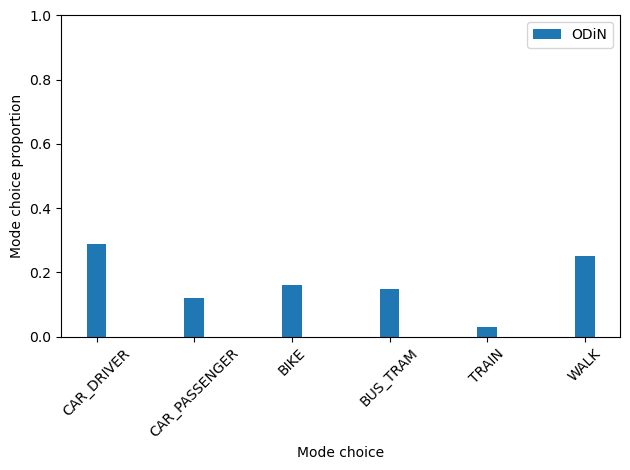

In [4]:
#entry1 = optimal_parameterset_simulation.values.flatten().tolist()
entry2 = observed_values.values.flatten().tolist()
#entry3 = uncalibrated_result.values.flatten().tolist()

columns = observed_values.columns.tolist()

# Create a list of indices for the x-axis
x = np.arange(len(columns))

# Plot the grouped bar chart using matplotlib
#plt.bar(x - 0.2, entry1, width=0.2, label='Optimal parameter set')
plt.bar(x, entry2, width=0.2, label='ODiN')
#plt.bar(x + 0.2, entry3, width=0.2, label='Uncalibrated')

plt.xlabel('Mode choice')
plt.ylabel('Mode choice proportion')
#plt.title('Evaluation of optimal parameter set')
plt.xticks(x, columns, rotation=45)
plt.ylim(0.0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
best_parameter_set_with_fitness

array([1.85026932, 0.06657028, 0.05263901, 0.99746323, 9.73578644])